# Task 1 : Observation Model Derivation

## Feedback Model - with biases

The state vector $x$ with gyroscope and accelrometer bias is defined as

$x = [L, \lambda, h, \phi, \theta, \psi, v_{N}, v_{E}, v_{D}, b_{ax}, b_{ay}, b_{az}, b_{gx}, b_{gy}, b_{gz}]$

The measeurement vector $z$ is

$z = [L, \lambda, h, v_{N}, v_{E}, v_{D}]$

Then the resulting measurement model is

$ z = Cx $

with $C = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}$

## Feedforward Model - with error states

The state vector $x$ with error states is defined as

$x = [L, \lambda, h, \phi, \theta, \psi, v_{N}, v_{E}, v_{D}, e_{L}, e_{\lambda}, e_{h}]$

The measeurement vector $z$ is

$z = [L, \lambda, h, v_{N}, v_{E}, v_{D}]$

Then the resulting measurement model is

$ z = Cx $

with $C = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
\end{bmatrix}$

The implementation of the observation model is code is straightforward - just slice the state vector using the position and velcity indexes. This way we dont need to implement two different C matrices for feedback and feedforward model.

```python
p = x[:3]
v = x[6:9]
```

# Propagation Model Implementation

The propagation model is almost same for both the feedback and feedforward model as it just propagates the position, orientation and velocity by integrating the IMU data over one timestep. The only difference is that in the feedback model implementation the biases are subtacted from the corresponding gyroscope and accelerometer values before propagating them. The **propagation_model()** implements the propagation model, taking as inputs the previous state `X_prev`, the current angular velocity `w_b`, specific forces `f_b` and timestep `dt` and outputs the updated state vector `X_curr`

1. Extract previous states from the state vector - $x = [L, \lambda, h, \phi, \theta, \psi, v_{N}, v_{E}, v_{D}, b_{ax}, b_{ay}, b_{az}, b_{gx}, b_{gy}, b_{gz}]$ 

    ```python
    # extract prev states
    L,l,h = X_prev[:3]
    q = X_prev[3:6]
    v_n = X_prev[6:9]
    v_N,v_E,v_D = v_n
    b_g = X_prev[12:]
    b_a = X_prev[9:12]
    ```

2. For feedback model subtract biases from the angular velocity and specific force vectors. Otherwise for feedforward model , use the same inputs.

    ```python
    if MODEL_TYPE == 'feedback':
        w_i_b = w_i_b - b_g
        f_b = f_b - b_a
    ```

3. **Attitude Update**: Update the orientation euler angles using the given equations. Two crucial points to be noted: 
    a. The angles are in degrees, so they need to be converted  to radians wherever necesary.
    b. Angles need to be wrapped between 0-360 deg.

    ```python
    ###### ATTITUDE UPDATE
    w_e = earth.RATE*np.array([0,0,1])
    omega_i_e = skew(w_e)

    R_N,R_E,R_P = earth.principal_radii(L,h)

    w_e_n = np.zeros(3)
    w_e_n[0] = v_E / (R_E + h)
    w_e_n[1] = -v_N / (R_N + h)
    w_e_n[2] = -v_E * np.tan(np.deg2rad(L)) / (R_E + h)

    omega_e_n = skew(w_e_n)
    omega_i_b = skew(w_i_b)

    R_prev = Rotation.from_euler('xyz',q,degrees=True).as_matrix()

    R_curr = R_prev @ (np.eye(3) + omega_i_b * dt) - (omega_i_e + omega_e_n) @ R_prev * dt

    q_curr = Rotation.from_matrix(R_curr).as_euler('xyz',degrees=True)
    q_curr = wrap_to_360(q_curr)
    ```

4. **Velocity Update**: velocities updates based on the given euqations.

    ```python
    ###### VELOCITY UPDATE
    f_n = 0.5 * (R_prev + R_curr) @ f_b
    g_n = earth.gravity_n(L,h) 
    v_n_curr = v_n + dt * (f_n + g_n - (omega_e_n + 2*omega_i_e) @ v_n)
    ```

5. **Position Update**: similarly positions are updated using the given equations

    ```python
    ###### POSITION UPDATE
    v_N_curr,v_E_curr,v_D_curr = v_n_curr

    h_curr = h - dt/2 * (v_D + v_D_curr)

    L_curr_rad = np.deg2rad(L) + dt/2 * (v_N/(R_N + h) + v_N_curr/(R_N + h_curr))
    L_curr = np.rad2deg(L_curr_rad)

    R_N_curr,R_E_curr,R_P_curr = earth.principal_radii(L_curr,h_curr)
    l_curr_rad = np.deg2rad(l) + dt/2 * (v_E/((R_E + h)*np.cos(np.deg2rad(L))) + v_E_curr/((R_E_curr + h_curr)*np.cos(np.deg2rad(L_curr))))
    l_curr = np.rad2deg(l_curr_rad)
    ```

6. An updateed state vector is constructed using all the updated position, orientation and velcoity values.

    ```python
    X_curr = np.hstack((L_curr,l_curr,h_curr,q_curr,v_n_curr,b_a,b_g))
    return X_curr
    ```



# Task 2: Nonlinear Error State implementation

# Task 3: Nonlinear Full State implementation


## Tuning Process and Measurement Covariances


# Task 4: Discussion and performance analysis

I utilized python's tqdm module to moniter the progress and loosely measure the time taken to process the dataset (the time measurements are heavily dependent on system performance and the not the code itself, but it may help us compare both models objectively)


100%|██████████| 21600/21600 [01:31<00:00, 236.78it/s]


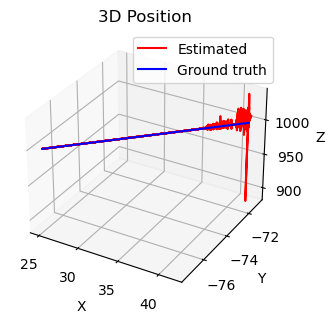

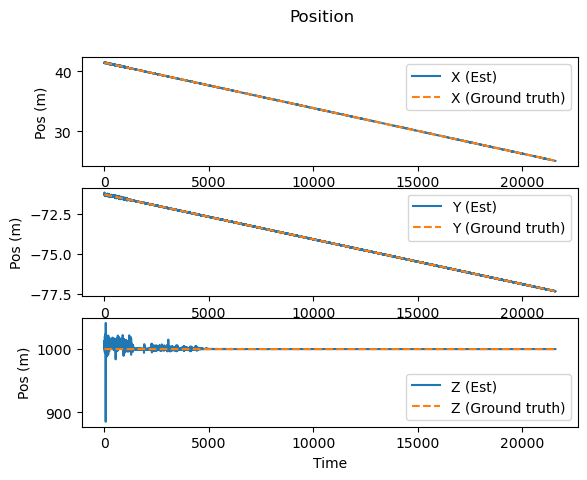

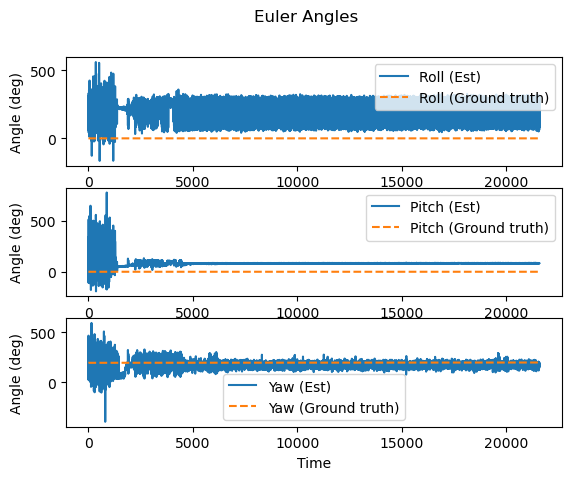

In [2]:
from ins_gnss import ins_gnss
model = 'feedback'
ins_gnss(model)